In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from torch.nn import Unfold
from torchvision.ops import sigmoid_focal_loss

In [92]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2
lane_unit = 200
time_span = 100
hidden_size = 64
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0830\models\train_6"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_13.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()

BidirectionalLSTMLaneReconstructor(
  (encoder): LSTM(200, 64, num_layers=2, batch_first=True, bidirectional=True)
  (decoder): LSTM(128, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=128, out_features=200, bias=True)
  (sigmoid): Sigmoid()
)

In [93]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0830\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
# find out the number of 1 over the total number of elements
positive_ratio = []
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    positive_ratio.append(np.float32(((target == 1).sum() / target.numel()).cpu().numpy())) 
    

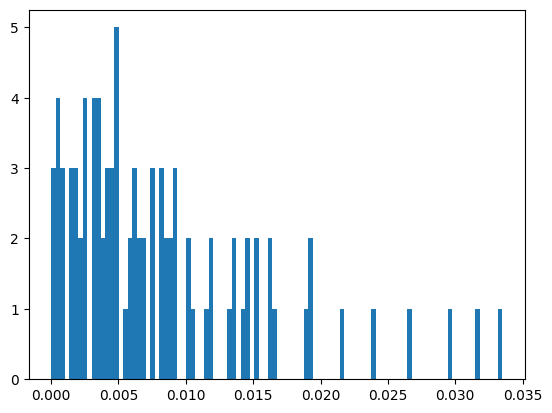

In [613]:
plt.hist(positive_ratio, bins=100)
plt.show()

In [468]:
speed_profile = []
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    break
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask_0 = (target == 1)
    speed_profile.append(speed[mask_0].cpu().numpy())

# speed_profile = np.concatenate(speed_profile)

    

  0%|          | 0/10954 [00:02<?, ?it/s]


In [4]:
# times new roman font
plt.rcParams['font.family'] = 'Times New Roman'

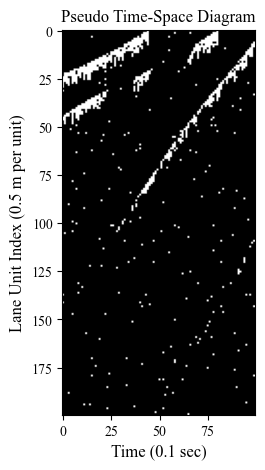

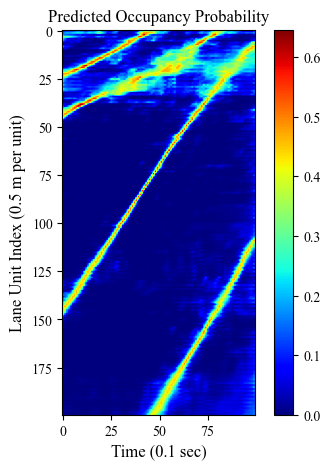

In [78]:
data = val_dataset[448]
post_occ_X = data['post_occ_X']
target = data['target']
output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()
plt.figure(figsize=(5,5))
plt.imshow(post_occ_X, cmap='gray')
plt.title('Pseudo Time-Space Diagram',fontsize=12)
plt.xlabel('Time (0.1 sec)',fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)',fontsize=12)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\pseudo_time_space.png',dpi = 300)
plt.show()
plt.figure(figsize=(5,5))
# plot output using heatmap with colorbar from 0 to 1
plt.imshow(numpy_ouput, cmap='jet')
plt.title('Predicted Occupancy Probability',fontsize=12)
plt.xlabel('Time (0.1 sec)',fontsize=12)
plt.ylabel('Lane Unit Index (0.5 m per unit)',fontsize=12)
plt.colorbar()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\predicted_occupancy.png',dpi = 300)
plt.show()

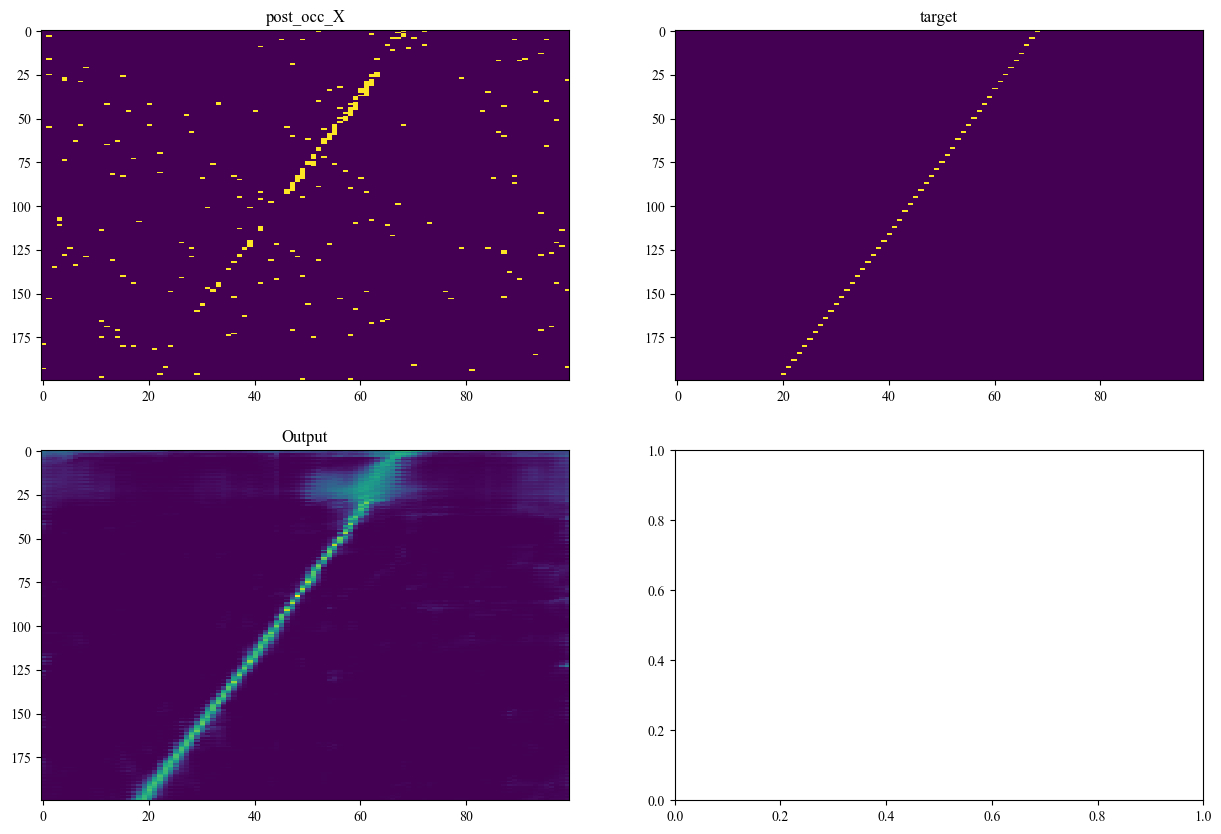

In [79]:
data = val_dataset[890]
post_occ_X = data['post_occ_X']
target = data['target']
output = best_model(post_occ_X.unsqueeze(0).to(device))
numpy_ouput = output.squeeze(0).detach().cpu().numpy()
# post_occ_X.shape
post_occ_X = post_occ_X.squeeze(0).detach().cpu().numpy()
# plot the post_occ_X, target, and output, put the target and post_occ_X in the same plot, output in another plot
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].imshow(post_occ_X, aspect='auto', interpolation='none')
ax[0, 0].set_title('post_occ_X')
ax[0, 1].imshow(target, aspect='auto', interpolation='none')
ax[0, 1].set_title('target')
ax[1, 0].imshow(numpy_ouput , aspect='auto', interpolation='none')
ax[1, 0].set_title('Output')
plt.show()

In [126]:
test_diagram = np.load(r"D:\TimeSpaceDiagramDataset\9th&VirTestDiagram\lane_2.npy")
# make it upside down
test_diagram = np.flipud(test_diagram)
# pad zeros to make it 200 x-1
original_shape = test_diagram.shape
padding = np.zeros((200 - test_diagram.shape[0], test_diagram.shape[1]))
test_diagram = np.concatenate((test_diagram,padding), axis=0)
test_diagram_unfold = torch.FloatTensor(test_diagram).to(device)
original_shape = test_diagram.shape
stride = 1
test_diagram_unfold = test_diagram_unfold.unfold(1, time_span, stride).permute(1, 0, 2).contiguous()
with torch.no_grad():
    feed_batch = 32
    output = []
    for i in range(0, test_diagram_unfold.size(0), feed_batch):
        output.append(best_model(test_diagram_unfold[i:i+feed_batch]))
    output = torch.cat(output, dim=0)
whole_output = torch.zeros(original_shape).to(device)
for i in range(0, output.size(0), stride):
    whole_output[:,i:i+time_span] += output[i]
whole_output = whole_output.cpu().numpy()

In [127]:
from DDBSCAN import Raster_DBSCAN

In [128]:
# crop to the original shape
whole_output = whole_output[:150, :original_shape[1]]
test_diagram = test_diagram[:150, :original_shape[1]]

In [129]:
db = Raster_DBSCAN(Td_map_szie=whole_output.shape, window_size=[7,13],eps = 1,min_samples=3)
Labels = db.fit_predict(whole_output > 30,Foreground_map=whole_output > 30)

In [130]:
import matplotlib.colors as mcolors
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

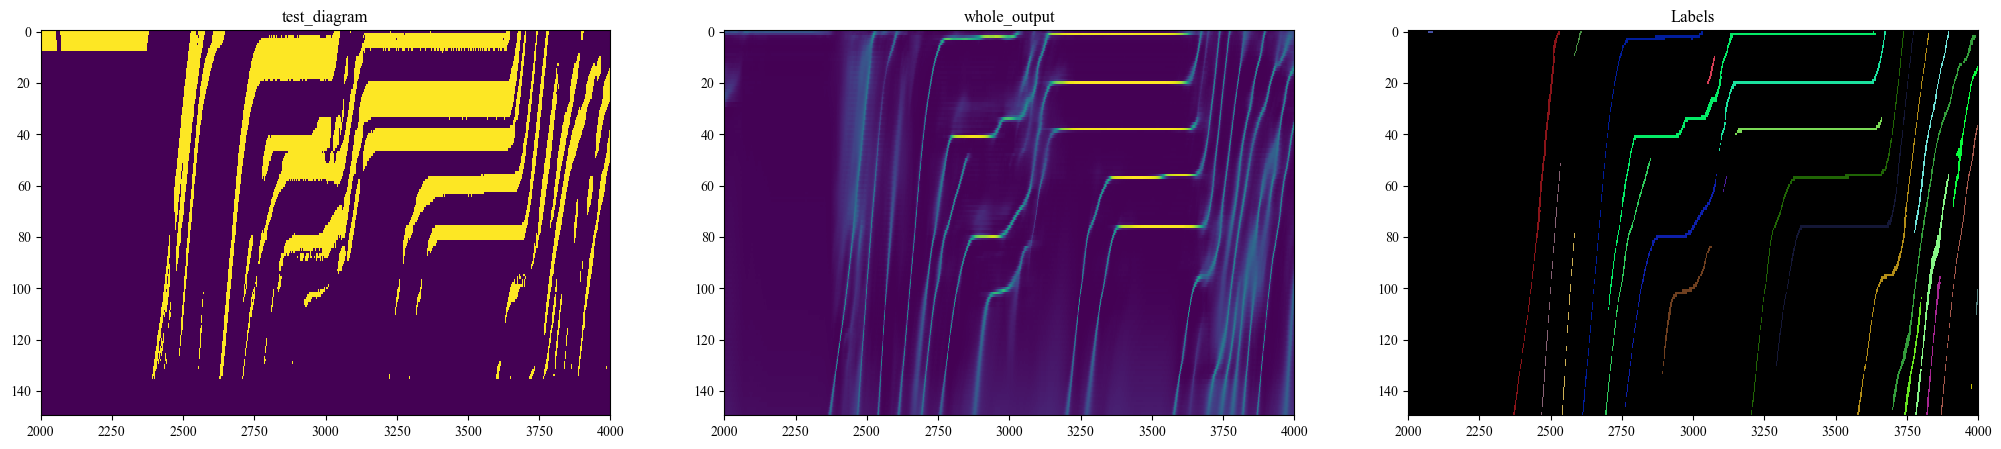

In [131]:
# plot test_diagram, and whole_output
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
start_frame = 2000
end_frame = 4000
ax[0].imshow(test_diagram, aspect='auto', interpolation='none')
ax[0].set_xlim(start_frame, end_frame)
ax[0].set_title('test_diagram')
ax[1].imshow(whole_output, aspect='auto', interpolation='none')
ax[1].set_title('whole_output')
ax[1].set_xlim(start_frame, end_frame)
ax[2].imshow(Labels, aspect='auto', interpolation='none', cmap=colormap)
ax[2].set_title('Labels')
ax[2].set_xlim(start_frame, end_frame)

plt.show()

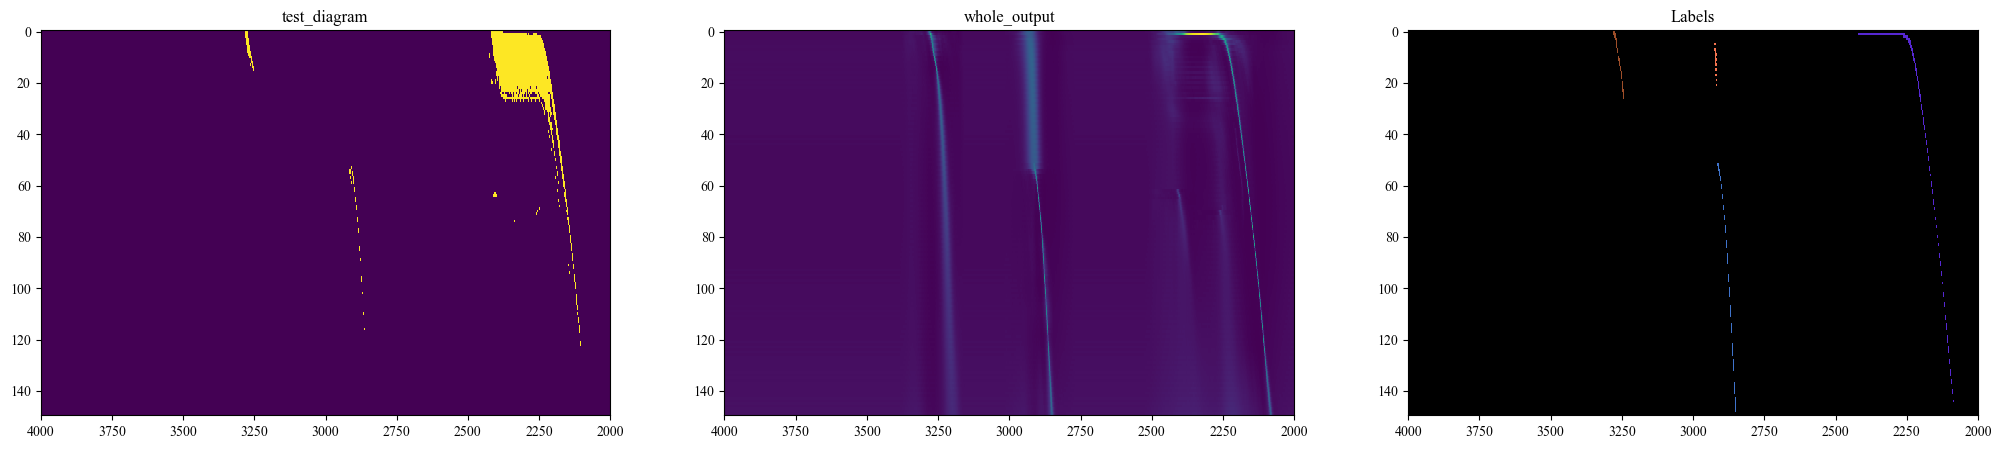

In [91]:
# plot test_diagram, and whole_output
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
start_frame = 4000
end_frame = 2000
ax[0].imshow(test_diagram, aspect='auto', interpolation='none')
ax[0].set_xlim(start_frame, end_frame)
ax[0].set_title('test_diagram')
ax[1].imshow(whole_output, aspect='auto', interpolation='none')
ax[1].set_title('whole_output')
ax[1].set_xlim(start_frame, end_frame)
ax[2].imshow(Labels, aspect='auto', interpolation='none', cmap=colormap)
ax[2].set_title('Labels')
ax[2].set_xlim(start_frame, end_frame)

plt.show()